## Pipeline ETL e Análise Exploratória de Dados: Microdados ENADE 2021

Este notebook documenta o processo de extração, transformação e carga (ETL) e a análise exploratória de dados (EDA) aplicados aos microdados do ENADE (Edição 2021). O objetivo central é investigar quantitativamente a correlação entre o sucesso acadêmico e fatores socioeconômicos — especificamente renda familiar, motivação de escolha e categoria administrativa da IES — através da comparação entre os extremos de desempenho (pior e melhor). O escopo da análise limita-se aos cursos de Ciência da Computação (Bacharelado).

O notebook está dividido em duas seções principais: 
1. Extração e tratamento dos microdados brutos, incluindo limpeza e definição das variáveis para cruzamento dos dados.
2. Análise visual com gráficos comparativos para identificar disparidades entre os grupos de pior e melhor desempenho.

Foram utilizadas as seguintes bases dos microdados oficiais do INEP:
- microdados2021_arq1.txt
- microdados2021_arq3.txt
- microdados2021_arq32.txt

O código é parte das pesquisas desenvolvidas no projeto de Iniciação Científica *"Explorando Horizontes: Tecnologias Computacionais Aplicadas à Comunidade através dos Cursos do Núcleo de Computação da Politécnica Uninter (N-CPU)"*.

---

### 1. Configurações, Extração e Tratamento

A fase inicial foca na extração e processamento de três bases de microdados. Para contornar a inexistência de uma chave primária para integração, utilizou-se uma ordenação determinística por código do curso (CO_CURSO) seguida de validação de integridade. Após unificar e filtrar os dados para o curso de Ciência da Computação, realizou-se a tipagem correta, limpeza e engenharia de atributos. O produto final é uma base unificada e tratada para a análise comparativa entre o 1º e o 4º quarto de desempenho.

#### 1.1 Configurações

In [89]:
# Bibliotecas necessárias
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [90]:
# Configurações globais para plots
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (8, 6)

# Tamanho da fonte
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['xtick.labelsize'] = 11
plt.rcParams['ytick.labelsize'] = 11
plt.rcParams['legend.fontsize'] = 11

# Remove a borda superior e direita
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False

#### 1.2 Extração e Tratamento dos Dados

In [91]:
## 1. Extração de dados de três bases diferentes
# arq1: informações da edição, curso e IES
df_arq1 = pd.read_csv('microdados2021_arq1.txt', sep=';', encoding='iso-8859-1', 
                      usecols=['NU_ANO', 'CO_GRUPO', 'CO_ORGACAD', 'CO_CATEGAD', 'CO_CURSO'],
                      low_memory=False)
# arq3: nota e renda familiar
df_arq3 = pd.read_csv('microdados2021_arq3.txt', sep=';', encoding='iso-8859-1', 
                      usecols=['NU_ANO', 'CO_CURSO', 'NT_GER', 'CO_RS_I8'],
                      dtype={'CO_RS_I8': str, 'NT_GER': str},
                      low_memory=False)
# arq32: questionário (pergunta 26)
df_arq32 = pd.read_csv('microdados2021_arq32.txt', sep=';', encoding='iso-8859-1', 
                       usecols=['NU_ANO', 'CO_CURSO', 'QE_I26'],
                       low_memory=False)

# 2. Ordenação das linhas por curso
df_arq1 = df_arq1.sort_values(by=['CO_CURSO']).reset_index(drop=True)
df_arq3 = df_arq3.sort_values(by=['CO_CURSO']).reset_index(drop=True)
df_arq32 = df_arq32.sort_values(by=['CO_CURSO']).reset_index(drop=True)

# Verificação de alinhamento das linhas
if not (df_arq1['CO_CURSO'].equals(df_arq3['CO_CURSO']) and df_arq1['CO_CURSO'].equals(df_arq32['CO_CURSO'])):
    raise ValueError("ERRO: Não foi possível alinhar as linhas dos três arquivos com base em CO_CURSO.")
print("Linhas alinhadas com sucesso entre os três arquivos.")

# 3. Merge
df = df_arq1.copy()
df['NT_GER'] = df_arq3['NT_GER']
df['CO_RS_I8'] = df_arq3['CO_RS_I8']
df['QE_I26'] = df_arq32['QE_I26']

# 4. Filtro: Ciência da Computação
df = df[df['CO_GRUPO'] == 4004] 

# 5. Limpeza de dados nulos e conversão de tipos
df['NT_GER'] = pd.to_numeric(df['NT_GER'].astype(str).str.replace(',', '.'), errors='coerce')
df = df[df['CO_RS_I8'] != '*']
df = df.dropna(subset=['NT_GER', 'CO_RS_I8', 'QE_I26'])

# 6. Definição dos quartos
df['QUARTO'] = pd.qcut(df['NT_GER'], q=[0, 0.25, 0.5, 0.75, 1.0], labels=['1º Quarto (Pior)', '2º Quarto', '3º Quarto', '4º Quarto (Melhor)'])

## 7. Mapeamento de variáveis
df['TIPO_IES'] = df['CO_CATEGAD'].map({1: 'Pública', 2: 'Pública', 3: 'Pública', 4: 'Privada', 5: 'Privada', 6: 'Privada', 7: 'Privada'})
df['RENDA_ALTA'] = df['CO_RS_I8'].isin(['E', 'F', 'G'])
df['MOTIVACAO_QUALIDADE'] = df['QE_I26'] == 'F'

# 8. Filtro: 1o e 4o quartos
df_extremos = df[df['QUARTO'].isin(['1º Quarto (Pior)', '4º Quarto (Melhor)'])].copy()
df_extremos['QUARTO'] = df_extremos['QUARTO'].cat.remove_unused_categories()

print(f"Sucesso! Base pronta e verificada. Total de alunos: {len(df_extremos)}")
print(df_extremos.head())

Linhas alinhadas com sucesso entre os três arquivos.
Sucesso! Base pronta e verificada. Total de alunos: 4363
     NU_ANO  CO_CURSO  CO_CATEGAD  CO_ORGACAD  CO_GRUPO  NT_GER CO_RS_I8  \
217    2021        36           1       10028      4004    54.5        D   
219    2021        36           1       10028      4004    25.7        C   
221    2021        36           1       10028      4004    46.7        D   
227    2021        36           1       10028      4004    17.2        C   
229    2021        36           1       10028      4004    17.6        B   

    QE_I26              QUARTO TIPO_IES  RENDA_ALTA  MOTIVACAO_QUALIDADE  
217      A  4º Quarto (Melhor)  Pública       False                False  
219      F    1º Quarto (Pior)  Pública       False                 True  
221      I  4º Quarto (Melhor)  Pública       False                False  
227      A    1º Quarto (Pior)  Pública       False                False  
229      A    1º Quarto (Pior)  Pública       False       

---
### 2. Análise
Esta seção investiga visualmente as disparidades socioeconômicas e institucionais comparando os extremos (1º quarto vs 4º quarto). Utilizam-se gráficos de barras para ilustrar a frequência relativa de Renda Familiar, Motivação de Escolha da IES e Categoria Administrativa, evidenciando as disparidades entre os perfis de pior e melhor desempenho.

#### 2.1 Renda Familiar vs Desempenho
*Qual é a diferença na proporção de alunos de renda familiar alta entre o grupo de melhor desempenho e o grupo de pior desempenho?*

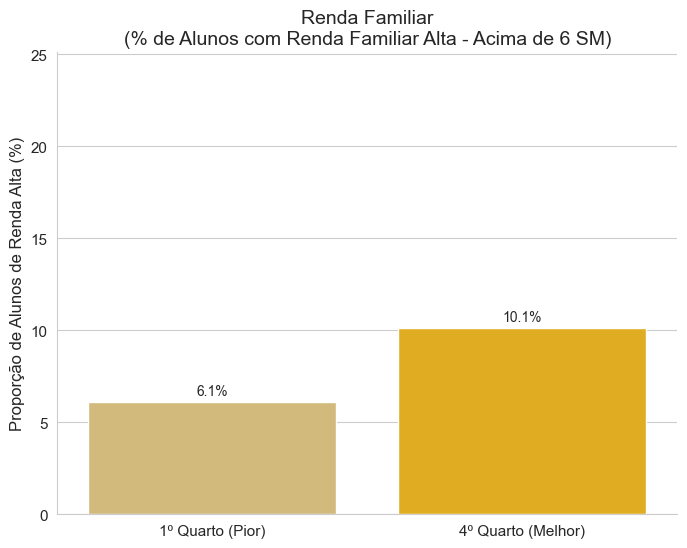

In [92]:
## Renda Familiar (Alta)

# Cálculo da % de alunos com renda familiar alta por quarto
resumo_renda = df_extremos.groupby('QUARTO', observed=True)['RENDA_ALTA'].mean() * 100
resumo_renda = resumo_renda.reset_index()

# Barplot
plt.figure()

grafico = sns.barplot(
    data=resumo_renda, 
    x='QUARTO', 
    y='RENDA_ALTA', 
    hue='QUARTO',
    palette=["#dfc16e", "#ffbc03"],
    legend=False
)

# Textos
plt.title('Renda Familiar\n(% de Alunos com Renda Familiar Alta - Acima de 6 SM)')
plt.ylabel('Proporção de Alunos de Renda Alta (%)')
plt.xlabel('')

# Definir espaçamento do eixo y
plt.ylim(0, resumo_renda['RENDA_ALTA'].max() + 15)

# Adicionar os números em cima das barras
for i in grafico.containers:
    grafico.bar_label(i, fmt='%.1f%%', padding=3)

plt.show()

#### 2.2 Motivação de Escolha vs Desempenho
*A priorização da qualidade/reputação como motivo de escolha da IES está mais associada ao sucesso ou ao insucesso do aluno de Ciência da Computação?*

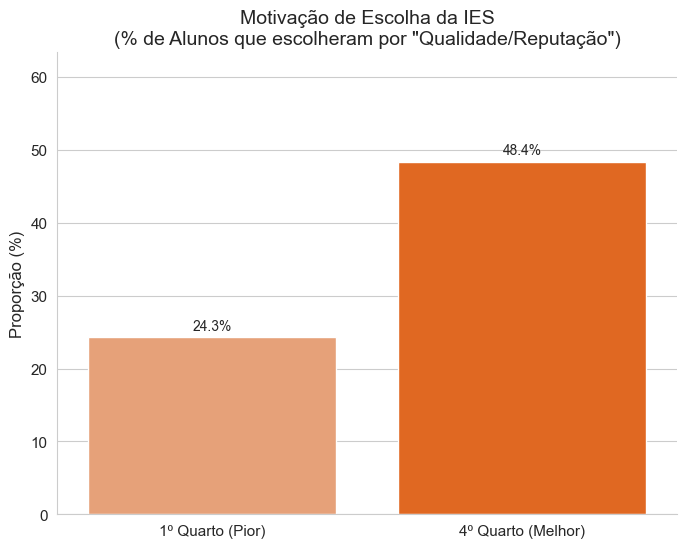

In [93]:
## Motivação (Qualidade/Reputação)

# Cálculo da % de alunos que escolheram a IES por "Qualidade/Reputação" por quarto
resumo_motivacao = df_extremos.groupby('QUARTO', observed=True)['MOTIVACAO_QUALIDADE'].mean() * 100
resumo_motivacao = resumo_motivacao.reset_index()

# Barplot
plt.figure()

grafico = sns.barplot(
    data=resumo_motivacao, 
    x='QUARTO', 
    y='MOTIVACAO_QUALIDADE', 
    hue='QUARTO',
    palette=["#f89c67", "#ff5f03"],
    legend=False
)

# Textos
plt.title('Motivação de Escolha da IES\n(% de Alunos que escolheram por "Qualidade/Reputação")')
plt.ylabel('Proporção (%)')
plt.xlabel('')

# Definir espaçamento do eixo y
plt.ylim(0, resumo_motivacao['MOTIVACAO_QUALIDADE'].max() + 15)

# Adicionar os números em cima das barras
for i in grafico.containers:
    grafico.bar_label(i, fmt='%.1f%%', padding=3)

plt.show()

#### 2.3 Categoria Administrativa vs Desempenho
*Entre os alunos com desempenho extremo (pior e melhor), qual categoria administrativa apresenta a maior disparidade percentual na concentração de alunos?*

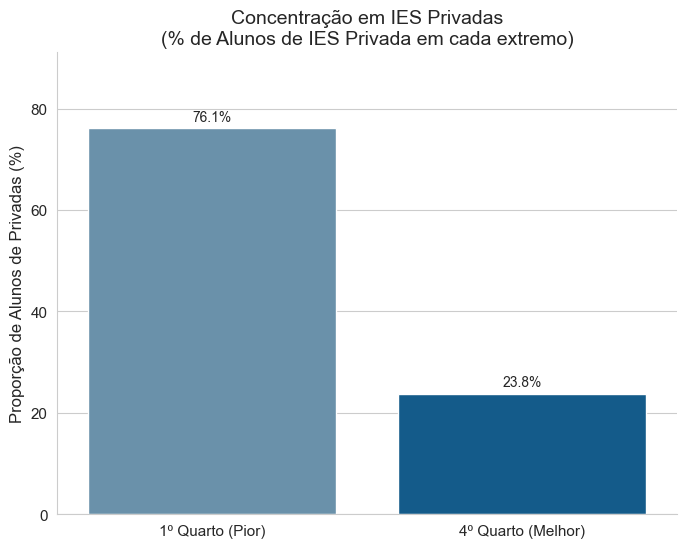

In [94]:
## Categoria Administrativa (Privadas)

# Coluna temporária 0 ou 1 para calcular a média
df_extremos['EH_PRIVADA'] = df_extremos['TIPO_IES'] == 'Privada'
# Cálculo da % de alunos de IES Privadas por quarto
resumo_admin = df_extremos.groupby('QUARTO', observed=True)['EH_PRIVADA'].mean() * 100
resumo_admin = resumo_admin.reset_index()

# Barplot
plt.figure()

grafico = sns.barplot(
    data=resumo_admin, 
    x='QUARTO', 
    y='EH_PRIVADA',
    hue='QUARTO', 
    palette=["#6093b4", '#005f9e'],
    legend=False
)

# Textos
plt.title('Concentração em IES Privadas\n(% de Alunos de IES Privada em cada extremo)')
plt.ylabel('Proporção de Alunos de Privadas (%)')
plt.xlabel('')

# Definir espaçamento do eixo y
plt.ylim(0, resumo_admin['EH_PRIVADA'].max() + 15)

# Adicionar os números em cima das barras
for i in grafico.containers:
    grafico.bar_label(i, fmt='%.1f%%', padding=3)

plt.show()